# Analysis Sparsity

Additional computations

## Imports:

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
import plotly.offline as ply
import plotly.graph_objs as go
ply.offline.init_notebook_mode(connected=True)

import os
import time
from collections import defaultdict
from copy import deepcopy
import skimage.restoration as skir


from IPython.display import clear_output
%load_ext autoreload

from PIL import Image
import bilevelsurrogates as Sur

#ymmv:
torch.backends.cudnn.benchmark = True

### GPU Setup:

In [2]:
device = torch.device('cuda:3')
dtype = torch.float

In [4]:
#Sur.deterministic()

## Data Generation:

In [5]:
noise = 25/255
clip = False
batch_size = 200

patch_cropping = torchvision.transforms.RandomCrop((64,64))
#patch_cropping = None

path = os.path.dirname(os.getcwd()) + '/data/BSDS300/' 
datasetTrain = Sur.data.BSDS300_for_denoising(path, noise_std=noise, augmentations=patch_cropping, flip=True,
                                              grayscale=True, clip_to_realistic=clip)
datasetTest = Sur.data.BSDS300_for_denoising(path, split = 'testing68', noise_std=noise,
                                             augmentations=patch_cropping,
                                             flip=True, grayscale=True, clip_to_realistic=clip)
datasetTestFull = Sur.data.BSDS300_for_denoising(path, split = 'testing68', noise_std=noise,
                                             augmentations=None, flip=True, grayscale=True,
                                             clip_to_realistic=clip)
datasetTest12 = Sur.data.Test12_for_denoising(os.path.dirname(os.getcwd()) + '/data/test12/', noise_std=noise,
                                             augmentations=None, clip_to_realistic=clip)
samples = Sur.data.Samples(datasetTrain, batch_size, device=device, dtype=dtype)

In [6]:
def energy_setup(model_setup):
    dictionary = Sur.DCTConvolution(in_channels=1, out_channels=48, kernel_size=7, mean=False,
                                    bias=model_setup['bias']).to(**model_setup['data'])
    torch.nn.init.orthogonal_(dictionary.weight, gain=1)
    #torch.nn.init.uniform_(dictionary.weight,-0.1, 0.1)
    energy = Sur.model.AnalysisSparsity(dictionary, model_setup)
    return energy

## Define Higher-level loss

In [7]:
loss = Sur.loss.PSNR()

# 1) Load Model and validate model

In [8]:
%autoreload 2
model_setup, training_setup, iterative_setup, state = torch.load(
    './energies/predictive-primal_large2019-05-26.pt', map_location=device)
model_setup['data'] = dict(device=device, dtype=dtype)
energy = energy_setup(model_setup)
energy.load_state_dict(state)
energy.to(device=device, dtype=dtype)

### Validate training loss

In [9]:
img_denoised, _ = Sur.training_error(energy, loss, samples);
samples.redraw_noise()
img_denoised, _ = Sur.training_error(energy, loss, samples);

TRAINING | MSE: 0.000902 | avg PSNR for these samples: 28.320,  Time: 00:17 mins
TRAINING | MSE: 0.000902 | avg PSNR for these samples: 28.313,  Time: 00:17 mins


In [9]:
samples.reset()
samples.step()
img_denoised, _ = Sur.training_error(energy, loss, samples);

TRAINING | MSE: 0.000885 | avg PSNR for these samples: 28.355,  Time: 00:18 mins


### Test 

In [ ]:
_, _ = Sur.testing_error(energy, loss, datasetTest);
_, _ = Sur.testing_error(energy, loss, datasetTestFull);
_, _ = Sur.test_twice_error(energy, loss, datasetTestFull, noise_est);
_, _ = Sur.testing_error(energy, loss, datasetTest12, batch_size=1);

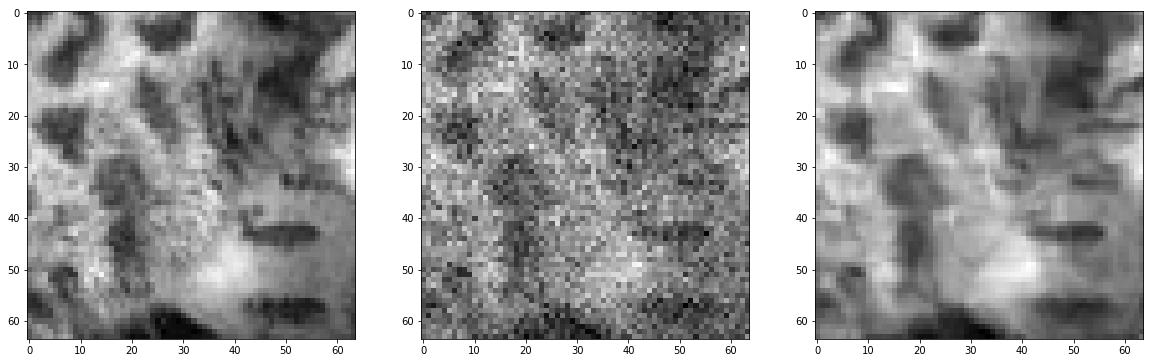

In [15]:
fig, axes = plt.subplots(1,3,figsize=(20, 10))
axes[0].imshow(samples.x[0,:,:,].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
axes[1].imshow(samples.y[0,:,:,].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
axes[2].imshow(img_denoised[0,:,:,:].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
fig.canvas.draw()

# 1a) Density function estimation

### Noisy samples

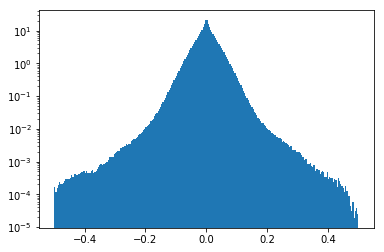

In [39]:
filter_responses = energy.operator(samples.y).detach()
plt.hist(filter_responses.view(-1).cpu().numpy(), range=(-0.5, 0.5), bins = 250, density=True, log=True);

### Clean samples

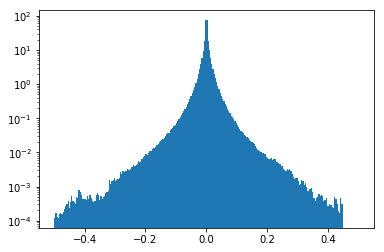

In [40]:
filter_responses = energy.operator(samples.x).detach()
plt.hist(filter_responses.view(-1).cpu().numpy(), range=(-0.5, 0.5), bins = 250, density=True, log=True);

# 1b) Sort filters by importance 

Dictionary norm is 2.271.


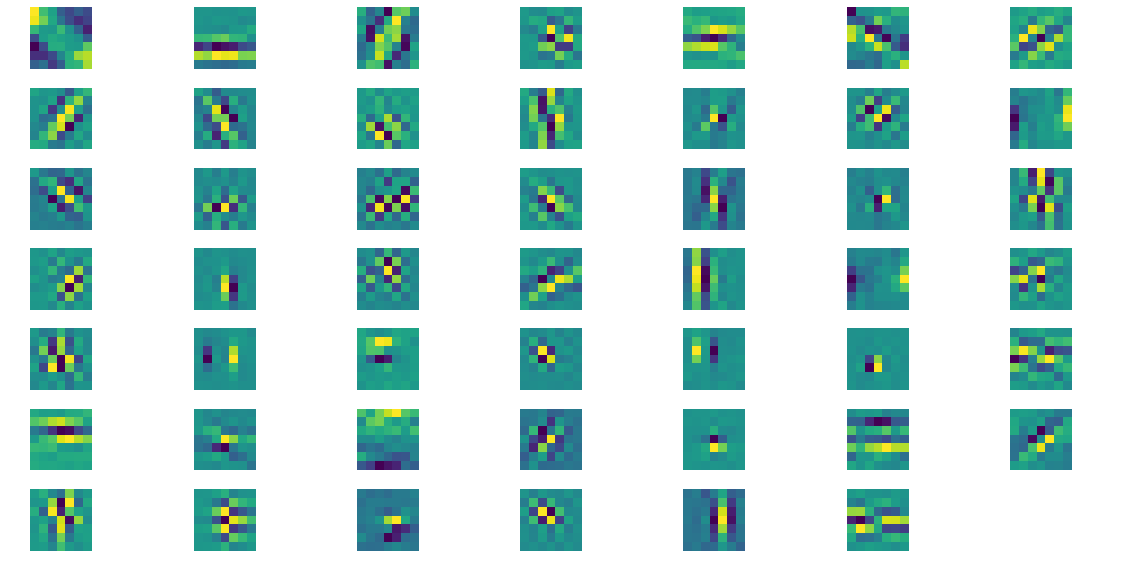

In [16]:
Sur.visualize(energy.operator)

In [17]:
filters = energy.operator.weight.clone().detach()
psnr_vals = []
for i in range(filters.shape[0]):
    energy.operator.weight[i, :, :, :].zero_()
    #_, metric = Sur.training_error(energy, loss, samples)
    _, metric = Sur.testing_error(energy, loss, datasetTestFull)
    psnr_vals.append(metric)
    energy.operator.weight[i, :, :, :] = filters[i, :, :, :].clone()
indices = np.argsort(psnr_vals)
energy.operator.weight = torch.nn.Parameter(energy.operator.weight[indices, :, :, :])

TESTING | MSE: 0.000893 | avg PSNR for the given testset: 27.936, Time: 01:26 mins---
TESTING | MSE: 0.000894 | avg PSNR for the given testset: 27.926, Time: 01:26 mins---
TESTING | MSE: 0.000890 | avg PSNR for the given testset: 27.950, Time: 01:26 mins---
TESTING | MSE: 0.000895 | avg PSNR for the given testset: 27.907, Time: 01:26 mins---
TESTING | MSE: 0.000894 | avg PSNR for the given testset: 27.922, Time: 01:26 mins---
TESTING | MSE: 0.000890 | avg PSNR for the given testset: 27.955, Time: 01:26 mins---
TESTING | MSE: 0.000892 | avg PSNR for the given testset: 27.923, Time: 01:26 mins---
TESTING | MSE: 0.000891 | avg PSNR for the given testset: 27.933, Time: 01:27 mins---
TESTING | MSE: 0.000896 | avg PSNR for the given testset: 27.896, Time: 01:26 mins---
TESTING | MSE: 0.000892 | avg PSNR for the given testset: 27.939, Time: 01:26 mins---
TESTING | MSE: 0.000890 | avg PSNR for the given testset: 27.941, Time: 01:25 mins---
TESTING | MSE: 0.000894 | avg PSNR for the given tests

Dictionary norm is 2.271.


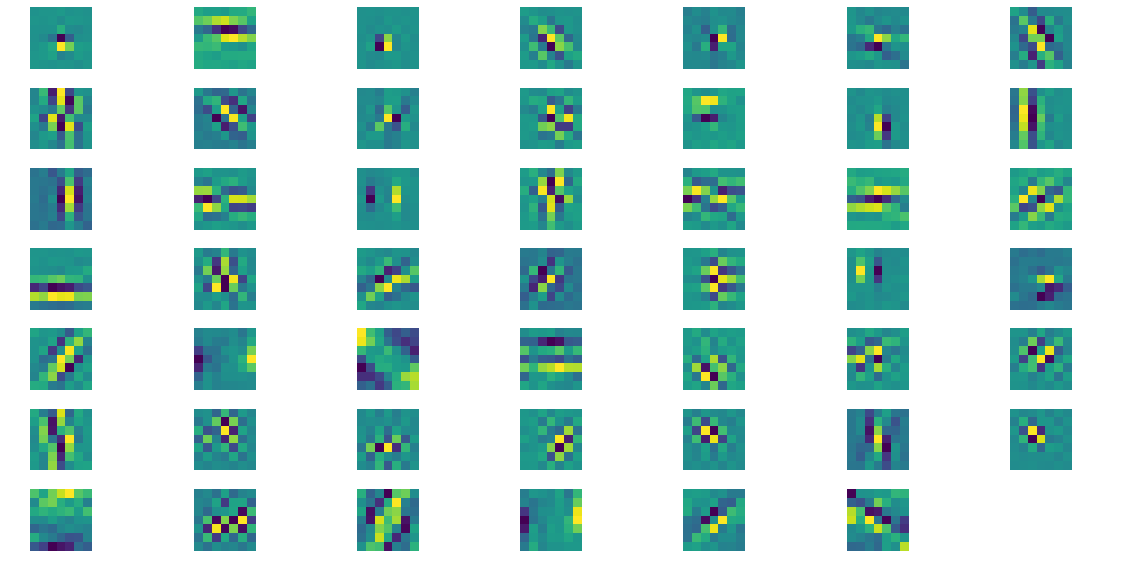

In [18]:
Sur.visualize(energy.operator)

# 1c) Remove filters by order of importance

In [19]:
filters = energy.operator.weight.clone().detach()
psnr_vals = []
for i in reversed(range(filters.shape[0])):
    energy.operator.weight[i, :, :, :].zero_()
    #_, metric = Sur.training_error(energy, loss, samples)
    _, metric = Sur.testing_error(energy, loss, datasetTestFull)
    psnr_vals.append(metric)
indices = np.argsort(psnr_vals)

# Return filters
energy.operator.weight = torch.nn.Parameter(energy.operator.weight[indices, :, :, :])

TESTING | MSE: 0.000888 | avg PSNR for the given testset: 27.961, Time: 01:25 mins---
TESTING | MSE: 0.000890 | avg PSNR for the given testset: 27.945, Time: 01:25 mins---
TESTING | MSE: 0.000893 | avg PSNR for the given testset: 27.926, Time: 01:27 mins---
TESTING | MSE: 0.000893 | avg PSNR for the given testset: 27.913, Time: 01:26 mins---
TESTING | MSE: 0.000895 | avg PSNR for the given testset: 27.892, Time: 01:26 mins---
TESTING | MSE: 0.000898 | avg PSNR for the given testset: 27.875, Time: 01:25 mins---
TESTING | MSE: 0.000900 | avg PSNR for the given testset: 27.845, Time: 01:25 mins---
TESTING | MSE: 0.000905 | avg PSNR for the given testset: 27.812, Time: 01:25 mins---
TESTING | MSE: 0.000915 | avg PSNR for the given testset: 27.745, Time: 01:24 mins---
TESTING | MSE: 0.000933 | avg PSNR for the given testset: 27.631, Time: 01:24 mins---
TESTING | MSE: 0.000962 | avg PSNR for the given testset: 27.472, Time: 01:24 mins---
TESTING | MSE: 0.001016 | avg PSNR for the given tests

/home/vsa_jonas/Dropbox/Documents_Hyperion/Python/BilevelSurrogates/bilevelsurrogates/subfunctions/normest.py:38: UserWarning:

Normest did not convergence to tolerance 1e-07 within 5000 iterations. Final tol was nan



TESTING | MSE: nan | avg PSNR for the given testset: nan, Time: 01:39 mins---


In [20]:
data = [go.Scatter(y=psnr_vals, name = 'PSNR')]
layout = go.Layout(
         xaxis=dict(
             type='linear',
             autorange=True,
             title='Iterations',
             automargin=True
             ),
         yaxis=dict(
             type='linear',
             autorange  = True,
             title='PSNR',
             automargin=True
         ),
         title = (f'PSNR value after removing the n-th least important filter')
)
fig = go.Figure(data=data, layout=layout)
ply.iplot(fig)

# 1d) Run filters through a non-convex model

In [35]:
nc_setup = deepcopy(model_setup)
nc_setup['alpha'] = 0.01
nc_setup['epsilon'] = 1
nc_setup['bias'] = False
nc_setup['norm'] = 'aniso'
# Possible regularizers are
# 'huber', 'l1', 'log-square', 'sqrt', log-abs
nc_setup['regularizer'] = 'log-abs' 
nc_setup['learn_scales'] = False
nc_energy = Sur.model.AnalysisNonconvex(energy.operator, nc_setup)

In [36]:
img_denoised, _ = Sur.training_error(nc_energy, loss, samples);

TRAINING | MSE: 0.000905 | avg PSNR for these samples: 28.259,  Time: 03:46 mins


# 2) Compare with optimal TV

In [16]:
tv_setup = deepcopy(model_setup)
tv_setup['norm'] = 'iso2'

# Define Model
grad = Sur.Convolution(1, 2, 3).initialize_gradient().to(device)
grad.weight.requires_grad = False
tv_energy = Sur.model.AnalysisSparsity(grad, tv_setup)


def grid_search(img_noisy):
    psnr_vals = []
    alpha_range = np.linspace(0.5*noise,0.8*noise,50)
    for alpha_test in alpha_range:
        tv_energy.setup['alpha'] = alpha_test
        output = tv_energy.minimize(samples.y)
        psnr = Sur.psnr_compute(output, samples.x)
        psnr_vals.append(psnr)
        print(f'Current alpha is {alpha_test}')
        print(f'Average psnr of denoised image is {psnr}')
    alpha = alpha_range[np.argmax(psnr_vals)]
    return alpha
    
tv_energy.setup['alpha'] = grid_search(samples.y)

Current alpha is 0.049019607843137254
Average psnr of denoised image is 26.63237494468689
Current alpha is 0.04961984793917567
Average psnr of denoised image is 26.683459968566893
Current alpha is 0.050220088035214085
Average psnr of denoised image is 26.733455085754393
Current alpha is 0.0508203281312525
Average psnr of denoised image is 26.782364015579223
Current alpha is 0.051420568227290915
Average psnr of denoised image is 26.830165691375733
Current alpha is 0.05202080832332933
Average psnr of denoised image is 26.876861925125123
Current alpha is 0.052621048419367746
Average psnr of denoised image is 26.922443313598635
Current alpha is 0.05322128851540616
Average psnr of denoised image is 26.966912212371827
Current alpha is 0.053821528611444576
Average psnr of denoised image is 27.01026651382446
Current alpha is 0.05442176870748299
Average psnr of denoised image is 27.052496061325073
Current alpha is 0.055022008803521406
Average psnr of denoised image is 27.093607845306398
Current

In [17]:
print(f'Optimal alpha by grid search is {tv_energy.setup["alpha"]:.3f}')
img_denoised, _ = Sur.training_error(tv_energy, loss, samples);
_, _ = Sur.testing_error(tv_energy, loss, datasetTestFull);

Optimal alpha by grid search is 0.078
TRAINING | MSE: 0.001068 | avg PSNR for these samples: 27.873,  Time: 00:01 mins
TESTING | MSE: 0.001051 | avg PSNR for the given testset: 27.407, Time: 00:06 mins---


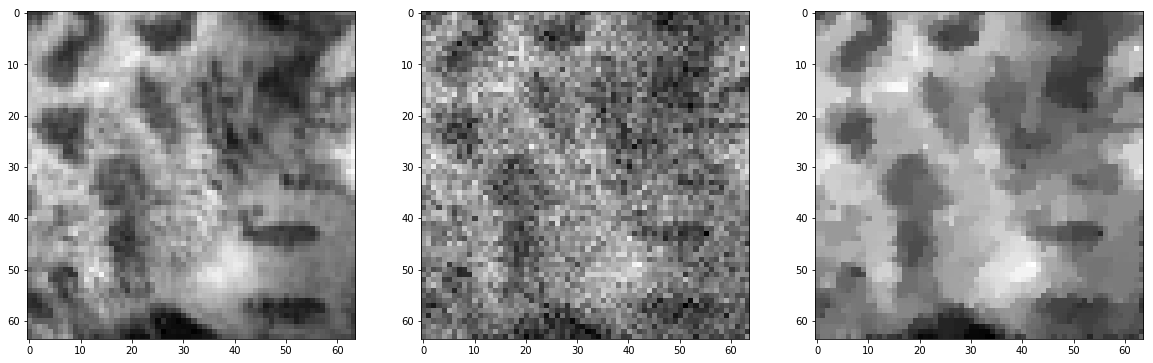

In [18]:
fig, axes = plt.subplots(1,3,figsize=(20, 10))
axes[0].imshow(samples.x[0,:,:,].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
axes[1].imshow(samples.y[0,:,:,].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
axes[2].imshow(img_denoised[0,:,:,:].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
fig.canvas.draw()

# 3) Fixed Point Property Test

In [19]:
import skimage.restoration as skir

# If using test data:
samples = Sur.data.Samples(datasetTest, batch_size, device=device, dtype=dtype)

In [20]:
psnr_est = defaultdict(list)
noise_est = defaultdict(lambda: [noise])

output = dict()
output['tv'], output['dict'] = [samples.y]*2

energies = dict()
energies['tv'], energies['dict'] = deepcopy(tv_energy), deepcopy(energy)

In [21]:
repetitions = 50

for iterations in range(repetitions):
    for key in output.keys():
        noise_est[key].append(skir.estimate_sigma(output[key].permute(2,3,0,1).cpu().numpy(),
                                    multichannel=True, average_sigmas=True))
        energies[key].setup['alpha'] *= noise_est[key][-1] / noise_est[key][-2]
        output[key] = energies[key].minimize(output[key])
        psnr_est[key].append(Sur.psnr_compute(output[key], samples.x))
        print(f'Estimated Noise for {key} is {noise_est[key][-1]:.4f} lead to psnr {psnr_est[key][-1]:.2f}')

Estimated Noise for tv is 0.1000 lead to psnr 27.28
Estimated Noise for dict is 0.1000 lead to psnr 28.16
Estimated Noise for tv is 0.0104 lead to psnr 27.17
Estimated Noise for dict is 0.0069 lead to psnr 28.20
Estimated Noise for tv is 0.0076 lead to psnr 27.05
Estimated Noise for dict is 0.0044 lead to psnr 28.17
Estimated Noise for tv is 0.0061 lead to psnr 26.93
Estimated Noise for dict is 0.0035 lead to psnr 28.13
Estimated Noise for tv is 0.0053 lead to psnr 26.82
Estimated Noise for dict is 0.0029 lead to psnr 28.09
Estimated Noise for tv is 0.0047 lead to psnr 26.73
Estimated Noise for dict is 0.0026 lead to psnr 28.05
Estimated Noise for tv is 0.0043 lead to psnr 26.64
Estimated Noise for dict is 0.0023 lead to psnr 28.01
Estimated Noise for tv is 0.0039 lead to psnr 26.56
Estimated Noise for dict is 0.0021 lead to psnr 27.98
Estimated Noise for tv is 0.0037 lead to psnr 26.48
Estimated Noise for dict is 0.0019 lead to psnr 27.94
Estimated Noise for tv is 0.0035 lead to psnr 

In [22]:
iter_range = np.arange(1, repetitions)
data = [go.Scatter(x = iter_range, y=psnr_est['tv'],
                   name = f'Repeating total variation ({samples.dataset.split} sample)')]
data.append(go.Scatter(x = iter_range, y=psnr_est['dict'],
                       name = f'Repeating dictionary approach ({samples.dataset.split} sample)'))

layout = go.Layout(
         xaxis=dict(
             type='log',
             autorange=True,
             title='Iterations',
             automargin=True
             ),
         yaxis=dict(
             type='log',
             autorange  = True,
             title='PSNR',
             automargin=True
         ),
         title = (f'PSNR value vs number of repetitions')
         )
fig = go.Figure(data=data, layout=layout)
ply.iplot(fig)

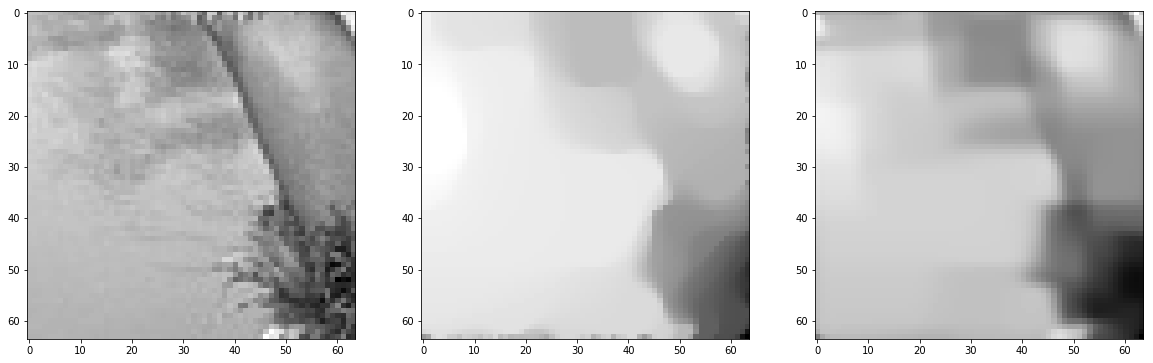

In [23]:
fig, axes = plt.subplots(1,3,figsize=(20, 10))
axes[0].imshow(samples.x[0,:,:,].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
axes[1].imshow(output['tv'][0,:,:,].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
axes[2].imshow(output['dict'][0,:,:,:].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
fig.canvas.draw()

# 4) Self-referential Denoising

In [26]:
batch_small = 200
small_samples = Sur.data.Samples(datasetTrain, batch_small, device=device, dtype=dtype)
self_samples = Sur.data.Samples(datasetTrain, batch_small, device=device, dtype=dtype)
self_samples.x = small_samples.y.clone()
self_samples.redraw_noise()

energy = energy_setup(model_setup)
    
training_setup = Sur.training.default_setup('DiscriminativeLearning')

subroutine = Sur.training.DiscriminativeLearning(energy, loss, self_samples, training_setup,
                                                 algorithm='predictive-primal')
iterative_setup = dict(linearizer_iterations=50, extrapolation_choice='n-margin',
                       backtracking=False, check_loss=True, verbose=True, tolerance=1e-4, stochastic=False)

optimizer =  Sur.training.IterativeLearning(subroutine, iterative_setup)
optimizer.run();


status: iteration    0, loss: 0.00006 (avg PSNR est: 39.411), tol: 100.000%
status: iteration 1000, loss: 0.00400 (avg PSNR est: 20.965), tol: 0.031%
status: iteration 2000, loss: 0.00392 (avg PSNR est: 21.057), tol: 0.016%
status: iteration 3000, loss: 0.00392 (avg PSNR est: 21.054), tol: 0.024%
status: iteration 4000, loss: 0.00394 (avg PSNR est: 21.030), tol: 0.047%
status: iteration 5000, loss: 0.00392 (avg PSNR est: 21.055), tol: 0.016%
status: iteration 6000, loss: 0.00393 (avg PSNR est: 21.050), tol: 0.137%
status: iteration 7000, loss: 0.00393 (avg PSNR est: 21.041), tol: 0.013%
status: finished  8000  iterations in 4 minutes and 30.35 seconds. tol: 0.009%
-- Iteration 0 done, tol: 100.000%, MSE: 0.003232, avg PSNR: 21.900
status: iteration    0, loss: 0.00196 (avg PSNR est: 24.066), tol: 100.000%
status: iteration 1000, loss: 0.00212 (avg PSNR est: 23.719), tol: 0.021%
status: iteration 2000, loss: 0.00216 (avg PSNR est: 23.645), tol: 0.045%
status: iteration 3000, loss: 0.002

status: finished   721  iterations in 0 minutes and 36.10 seconds. tol: 0.000%
-- Iteration 19 done, tol: 0.700%, MSE: 0.002793, avg PSNR: 22.543
status: iteration    0, loss: 0.00350 (avg PSNR est: 21.547), tol: 100.000%
status: finished   867  iterations in 0 minutes and 39.98 seconds. tol: 0.000%
-- Iteration 20 done, tol: 0.340%, MSE: 0.002783, avg PSNR: 22.558
status: iteration    0, loss: 0.00350 (avg PSNR est: 21.546), tol: 100.000%
status: iteration 1000, loss: 0.00349 (avg PSNR est: 21.564), tol: 0.022%
status: finished  1381  iterations in 1 minutes and 18.73 seconds. tol: 0.000%
-- Iteration 21 done, tol: 0.198%, MSE: 0.002778, avg PSNR: 22.567
status: iteration    0, loss: 0.00354 (avg PSNR est: 21.499), tol: 100.000%
status: iteration 1000, loss: 0.00351 (avg PSNR est: 21.542), tol: 0.003%
status: iteration 2000, loss: 0.00350 (avg PSNR est: 21.553), tol: 0.088%
status: iteration 3000, loss: 0.00351 (avg PSNR est: 21.542), tol: 0.021%
status: iteration 4000, loss: 0.00351 

status: iteration 1000, loss: 0.00348 (avg PSNR est: 21.576), tol: 0.004%
status: iteration 2000, loss: 0.00345 (avg PSNR est: 21.608), tol: 0.077%
status: finished  2921  iterations in 3 minutes and 20.03 seconds. tol: 0.000%
-- Iteration 39 done, tol: 0.220%, MSE: 0.002783, avg PSNR: 22.558
status: iteration    0, loss: 0.00344 (avg PSNR est: 21.619), tol: 100.000%
status: iteration 1000, loss: 0.00342 (avg PSNR est: 21.653), tol: 0.038%
status: iteration 2000, loss: 0.00343 (avg PSNR est: 21.639), tol: 0.002%
status: iteration 3000, loss: 0.00341 (avg PSNR est: 21.667), tol: 0.078%
status: iteration 4000, loss: 0.00342 (avg PSNR est: 21.653), tol: 0.006%
status: iteration 5000, loss: 0.00342 (avg PSNR est: 21.652), tol: 0.015%
status: finished  5511  iterations in 6 minutes and 18.46 seconds. tol: 0.000%
-- Iteration 40 done, tol: 0.149%, MSE: 0.002787, avg PSNR: 22.553
status: iteration    0, loss: 0.00353 (avg PSNR est: 21.517), tol: 100.000%
status: finished   618  iterations in 

In [27]:
print(Sur.psnr_compute(optimizer.x, small_samples.x))
img_denoised, _ = Sur.training_error(energy, loss, self_samples);
img_denoised, _ = Sur.training_error(energy, loss, small_samples);

21.934726610183716
TRAINING | MSE: 0.002786 | avg PSNR for these samples: 22.555,  Time: 00:07 mins
TRAINING | MSE: 0.001197 | avg PSNR for these samples: 26.560,  Time: 00:07 mins


Dictionary norm is 1.446.


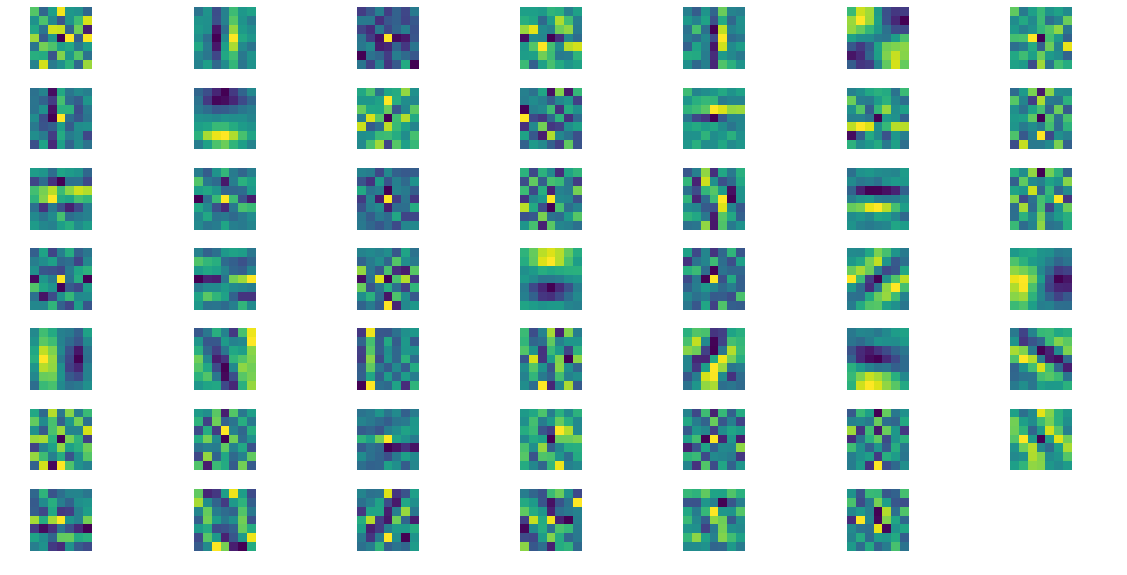

In [28]:
Sur.visualize(energy.operator)

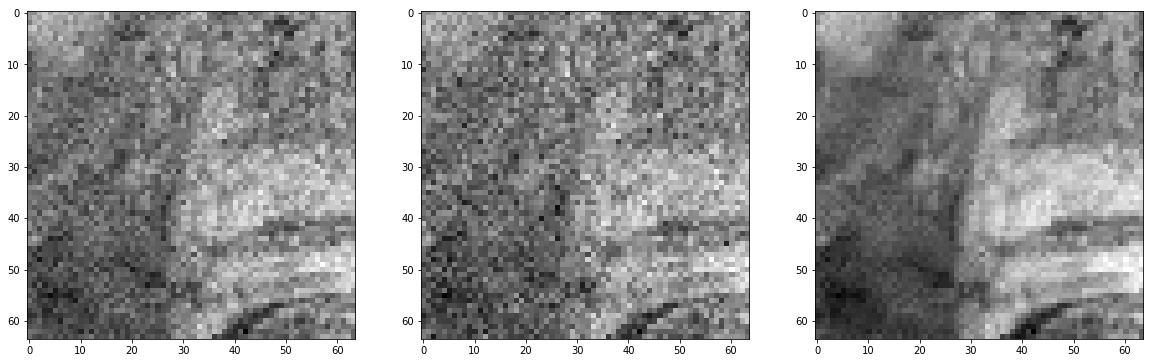

In [29]:
fig, axes = plt.subplots(1,3,figsize=(20, 10))
axes[0].imshow(self_samples.x[0,:,:,].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
axes[1].imshow(self_samples.y[0,:,:,].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
axes[2].imshow(img_denoised[0,:,:,:].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
fig.canvas.draw()

In [30]:
_, _ = Sur.testing_error(energy, loss, datasetTest);
_, _ = Sur.testing_error(energy, loss, datasetTestFull);
_, _ = Sur.test_twice_error(energy, loss, datasetTestFull);

TESTING | MSE: 0.001272 | avg PSNR for the given testset: 26.311, Time: 00:05 mins---
TESTING | MSE: 0.001159 | avg PSNR for the given testset: 26.571, Time: 01:24 mins---
TESTING | MSE: 0.000970 | avg PSNR for the given testset: 27.664, Time: 02:46 mins---


# Plotting

## save filters to pdf:

In [ ]:
# fig.savefig("filters_168_13_13.pdf", bbox_inches='tight', dpi=1200)